In [1]:
import torch
from torch.nn import functional as F
from matplotlib import pyplot as plt
import random

## Load data

In [2]:
!wget https://raw.githubusercontent.com/ncarkaci/TDKDictionaryCrawler/master/ortak_kelimeler.txt

--2024-06-26 11:42:38--  https://raw.githubusercontent.com/ncarkaci/TDKDictionaryCrawler/master/ortak_kelimeler.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 402869 (393K) [text/plain]
Saving to: ‘ortak_kelimeler.txt.1’

ortak_kelimeler.txt 100%[===================>] 393.43K  --.-KB/s    in 0.1s    

2024-06-26 11:42:39 (3.34 MB/s) - ‘ortak_kelimeler.txt.1’ saved [402869/402869]



In [3]:
with open("ortak_kelimeler.txt") as f:
    text = f.read()

In [4]:
words = text.split("\n")

In [5]:
long_text = text.replace("\n","")
ids = list(set(long_text))
len(ids)

29

In [6]:
ordinal_char_pairs = sorted([(ord(c),c) for c in ids])
ordinal_char_pairs

[(97, 'a'),
 (98, 'b'),
 (99, 'c'),
 (100, 'd'),
 (101, 'e'),
 (102, 'f'),
 (103, 'g'),
 (104, 'h'),
 (105, 'i'),
 (106, 'j'),
 (107, 'k'),
 (108, 'l'),
 (109, 'm'),
 (110, 'n'),
 (111, 'o'),
 (112, 'p'),
 (114, 'r'),
 (115, 's'),
 (116, 't'),
 (117, 'u'),
 (118, 'v'),
 (121, 'y'),
 (122, 'z'),
 (231, 'ç'),
 (246, 'ö'),
 (252, 'ü'),
 (287, 'ğ'),
 (305, 'ı'),
 (351, 'ş')]

## Encode & Decode Functions

In [7]:
ctoi = {c:i for i,(o,c) in enumerate(ordinal_char_pairs)}
itoc =  {i:c for i,(o,c) in enumerate(ordinal_char_pairs)}

In [8]:
ctoi['.']=len(ctoi)
itoc[len(itoc)]='.'

In [9]:
def encode(input:str):
    return [ctoi[c] for c in input]

def decode(ids):
    return "".join([itoc[i] for i in ids])

In [10]:
assert decode(encode("zemberek"))=='zemberek'

## Helpers

In [11]:
def plot_training_loss(nn):
    fig, axs = plt.subplots(1, 2, figsize=(20, 10))


    axs[0].plot(nn.losses, label="Neural net loss")
    axs[0].set_title('Losses')

    axs[1].plot([g[1] for g in nn.grads], label="Max")
    axs[1].plot([g[0] for g in nn.grads], label="Min")
    axs[1].plot([g[2] for g in nn.grads], label="Avg")
    axs[1].set_title('Gradients')
    axs[1].legend()

    plt.show()

## Prepare Training Data

In [12]:
def generate_data(words, block_size):
    xs, ys = [], []
    for w in words:
        context = [ctoi["."]]*block_size
        for c in w+'.':
            id = ctoi[c]

            xs.append(context)
            ys.append(id)

            context = context[1:]+[id]

    print(f"Generated {len(xs)} samples")

    xs = torch.tensor(xs)
    ys = torch.tensor(ys)

    return xs, ys

In [13]:
random.seed(13)
random.shuffle(words)

n = len(words)
n1 = int(n*0.8)
n2 = int(n*0.9)

In [14]:
LR = 50

## Train

In [15]:
class NGramLM:
    def __init__(self, n):

        self.n = n

        self.W = None

        # for logging
        self.losses = None
        self.grads = None

    def forward(self, ix):
        # Following two approaches are similar, second option is m ore efficient

        # Option 1 - use one hot vectors and matrix multiplication to get the logits
        # xenc = F.one_hot(xs, num_classes=30).float()
        # logits = xenc @ W  # log counts

        # Option 2 - use array indexing to get the logits
        logits = self.W[tuple(ix.T)]  # log counts

        # Softmax
        counts = logits.exp()
        probs = counts / counts.sum(dim=-1, keepdim=True)

        return probs

    def train(self, xs, ys, lr=10, steps=1000):
        self.losses = []
        self.grads = []

        self.W = torch.rand((30,)*self.n, requires_grad=True)

        W = self.W

        print(f"Using {len(xs)} samples")

        for i in range(steps):
            probs = self.forward(xs)

            # negative log likelihood
            loss = -probs[torch.arange(len(xs)), ys].log().mean()

            if i % 10 == 0:
                print(f"Step {i} | loss: {loss.item():.4f}")

            # backward
            W.grad = None
            loss.backward()

            # update weights
            W.data -= lr * W.grad

            # logging
            self.losses.append(loss.item())
            self.grads.append([
                W.grad.min().item(),
                W.grad.max().item(),
                W.grad.mean().item()]
            )

        print(f"loss: {loss.item():.4f}")

    def generate(self):
        reverse_offset = -self.n+1
        n_start_chars = self.n-1

        chars = torch.tensor([ctoi['.']]*n_start_chars, dtype=torch.int)
        while True:

            probs = self.forward(chars[reverse_offset:])
            assert probs.shape == (30,), f"{probs.shape=}"
            next_char = torch.multinomial(probs, 1, replacement=True)

            if next_char.item() == ctoi['.']:
                return decode(list(chars.numpy())[n_start_chars:])

            chars = torch.concat((chars, next_char), dim=-1)

### Bi-gram

In [16]:
block_size = 1
xs_train, ys_train = generate_data(words[:n1], block_size)
# xs_valid, ys_valid = generate_data(words[n1:n2], block_size)
# xs_test, ys_test = generate_data(words[n2:], block_size)

Generated 293606 samples


In [17]:
for i in range(10):
    print(decode(list(torch.concat((xs_train[i], ys_train[i,None])).numpy())))

.p
pa
an
nt
te
ei
iz
zm
m.
.f


In [18]:
torch.manual_seed(13)
nn2 = NGramLM(2)
nn2.train(xs_train, ys_train, LR)
# Using 293606 samples
# loss: 2.5332 (lr 10)
# loss: 2.5242 (lr 50)

Using 293606 samples
Step 0 | loss: 3.4499
Step 10 | loss: 2.7331
Step 20 | loss: 2.6385
Step 30 | loss: 2.6013
Step 40 | loss: 2.5815
Step 50 | loss: 2.5694
Step 60 | loss: 2.5613
Step 70 | loss: 2.5555
Step 80 | loss: 2.5511
Step 90 | loss: 2.5478
Step 100 | loss: 2.5451
Step 110 | loss: 2.5429
Step 120 | loss: 2.5411
Step 130 | loss: 2.5395
Step 140 | loss: 2.5382
Step 150 | loss: 2.5371
Step 160 | loss: 2.5361
Step 170 | loss: 2.5352
Step 180 | loss: 2.5344
Step 190 | loss: 2.5337
Step 200 | loss: 2.5331
Step 210 | loss: 2.5326
Step 220 | loss: 2.5321
Step 230 | loss: 2.5316
Step 240 | loss: 2.5312
Step 250 | loss: 2.5308
Step 260 | loss: 2.5305
Step 270 | loss: 2.5301
Step 280 | loss: 2.5298
Step 290 | loss: 2.5296
Step 300 | loss: 2.5293
Step 310 | loss: 2.5291
Step 320 | loss: 2.5288
Step 330 | loss: 2.5286
Step 340 | loss: 2.5284
Step 350 | loss: 2.5282
Step 360 | loss: 2.5281
Step 370 | loss: 2.5279
Step 380 | loss: 2.5277
Step 390 | loss: 2.5276
Step 400 | loss: 2.5274
Step 4

In [19]:
torch.manual_seed(35)
for i in range(10):
    print(nn2.generate())

atettı
ik
öncırısörarsı
kakl
satsabiçinorekom
bil
stlllıdaşapek
k
s
ir


/tmp/ipykernel_3361773/3327240340.py:20: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3675.)
  logits = self.W[tuple(ix.T)]  # log counts


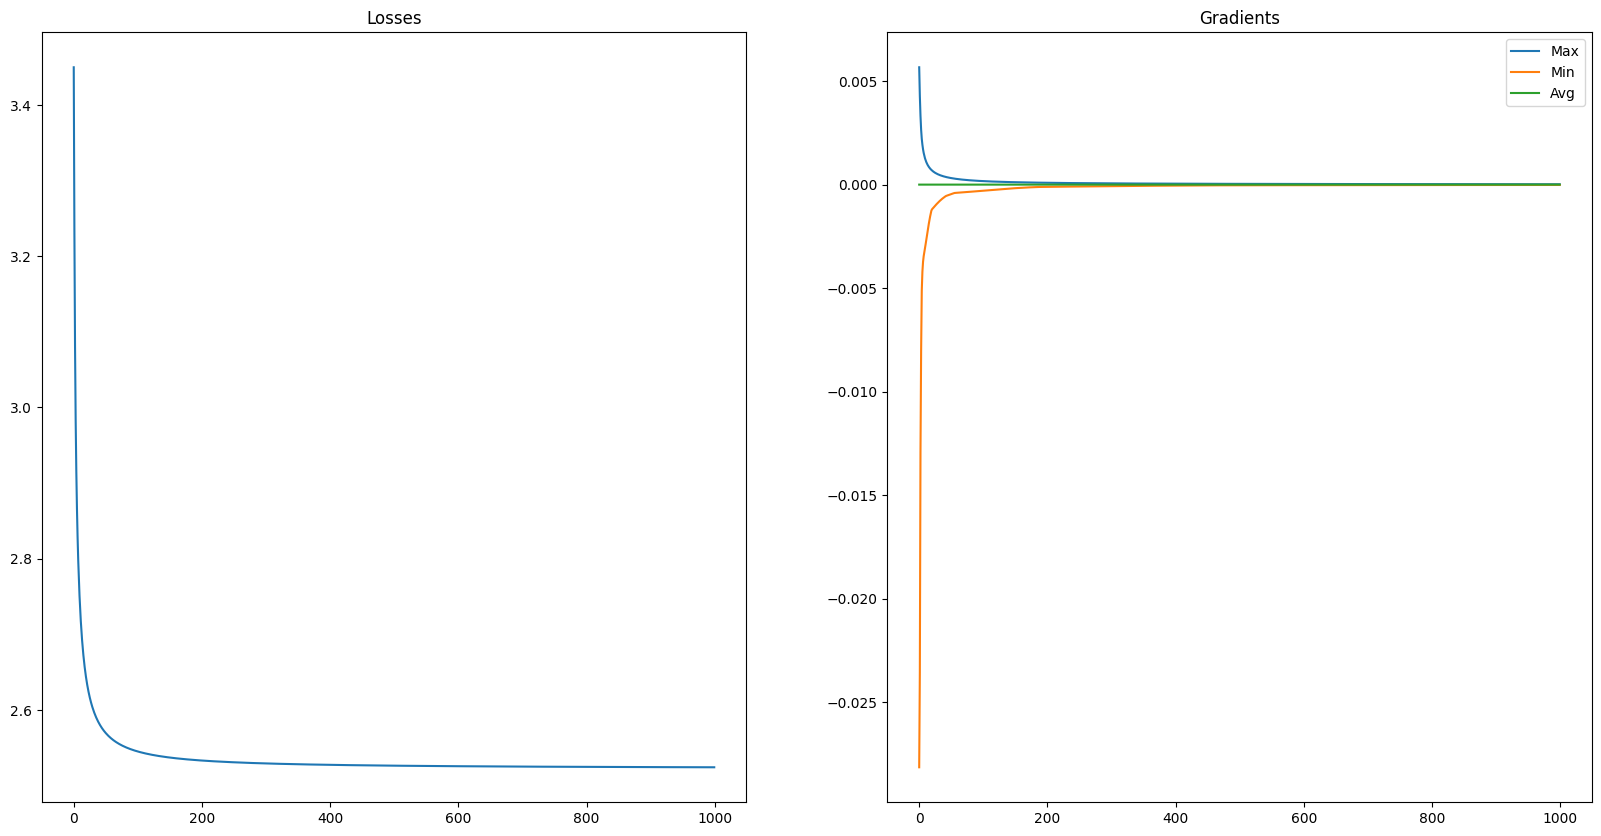

In [20]:
plot_training_loss(nn2)

### 3-gram

In [21]:
n = 2
xs_train, ys_train = generate_data(words[:n1], n)
# xs_valid, ys_valid = generate_data(words[n1:n2], n)
# xs_test, ys_test = generate_data(words[n2:], n)

Generated 293606 samples


In [22]:
for i in range(20):
    print(decode(list(torch.concat((xs_train[i], ys_train[i,None])).numpy())))

..p
.pa
pan
ant
nte
tei
eiz
izm
zm.
..f
.fa
fah
ahi
hiş
işe
şe.
..y
.ya
yap
apm


In [23]:
torch.manual_seed(13)
nn3 = NGramLM(3)
nn3.train(xs_train, ys_train, LR)

# Using 293606 samples
# loss: 2.3619 (lr 10)
# loss: 2.2073 (lr 50)

Using 293606 samples
Step 0 | loss: 3.4479
Step 10 | loss: 3.0415
Step 20 | loss: 2.8667
Step 30 | loss: 2.7623
Step 40 | loss: 2.6894
Step 50 | loss: 2.6348
Step 60 | loss: 2.5918
Step 70 | loss: 2.5568
Step 80 | loss: 2.5277
Step 90 | loss: 2.5030
Step 100 | loss: 2.4817
Step 110 | loss: 2.4631
Step 120 | loss: 2.4467
Step 130 | loss: 2.4321
Step 140 | loss: 2.4190
Step 150 | loss: 2.4071
Step 160 | loss: 2.3964
Step 170 | loss: 2.3865
Step 180 | loss: 2.3775
Step 190 | loss: 2.3692
Step 200 | loss: 2.3615
Step 210 | loss: 2.3543
Step 220 | loss: 2.3477
Step 230 | loss: 2.3415
Step 240 | loss: 2.3357
Step 250 | loss: 2.3302
Step 260 | loss: 2.3251
Step 270 | loss: 2.3203
Step 280 | loss: 2.3157
Step 290 | loss: 2.3114
Step 300 | loss: 2.3073
Step 310 | loss: 2.3034
Step 320 | loss: 2.2998
Step 330 | loss: 2.2963
Step 340 | loss: 2.2929
Step 350 | loss: 2.2897
Step 360 | loss: 2.2867
Step 370 | loss: 2.2838
Step 380 | loss: 2.2810
Step 390 | loss: 2.2784
Step 400 | loss: 2.2758
Step 4

In [24]:
torch.manual_seed(35)
for i in range(10):
    print(nn3.generate())

aoji
şaijy
muohrsöylık
gerel
satsabiliyonuk
müttırmflarkiridazkfnğ
kar
sayağlanlu
ot
döjşğçfjkvcğmpkın


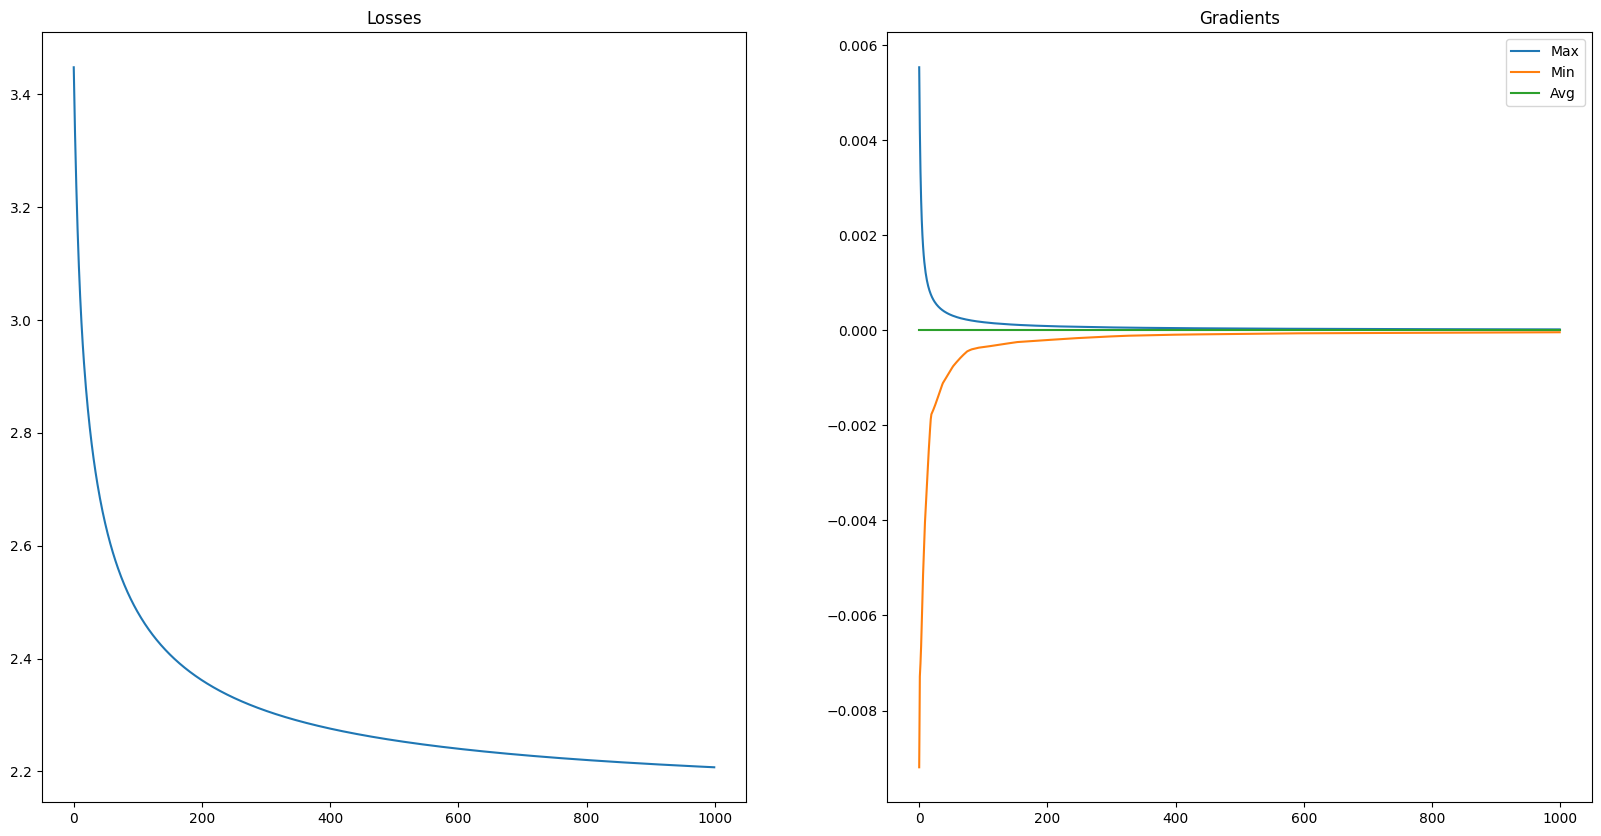

In [25]:
plot_training_loss(nn3)

## 4-gram

In [26]:
n = 3
xs_train, ys_train = generate_data(words[:n1], n)
# xs_valid, ys_valid = generate_data(words[n1:n2], n)
# xs_test, ys_test = generate_data(words[n2:], n)

Generated 293606 samples


In [27]:
for i in range(20):
    print(decode(list(torch.concat((xs_train[i], ys_train[i,None])).numpy())))

...p
..pa
.pan
pant
ante
ntei
teiz
eizm
izm.
...f
..fa
.fah
fahi
ahiş
hişe
işe.
...y
..ya
.yap
yapm


In [28]:
torch.manual_seed(13)
nn4 = NGramLM(4)
nn4.train(xs_train, ys_train, LR)

# Using 293606 samples
# loss: 2.5366 (lr 10)
# loss: 2.1221 (lr 50)

Using 293606 samples
Step 0 | loss: 3.4375
Step 10 | loss: 3.2028
Step 20 | loss: 3.0782
Step 30 | loss: 2.9958
Step 40 | loss: 2.9332
Step 50 | loss: 2.8825
Step 60 | loss: 2.8399
Step 70 | loss: 2.8030
Step 80 | loss: 2.7705
Step 90 | loss: 2.7415
Step 100 | loss: 2.7152
Step 110 | loss: 2.6912
Step 120 | loss: 2.6691
Step 130 | loss: 2.6487
Step 140 | loss: 2.6296
Step 150 | loss: 2.6117
Step 160 | loss: 2.5949
Step 170 | loss: 2.5790
Step 180 | loss: 2.5640
Step 190 | loss: 2.5497
Step 200 | loss: 2.5361
Step 210 | loss: 2.5231
Step 220 | loss: 2.5107
Step 230 | loss: 2.4988
Step 240 | loss: 2.4875
Step 250 | loss: 2.4765
Step 260 | loss: 2.4660
Step 270 | loss: 2.4558
Step 280 | loss: 2.4460
Step 290 | loss: 2.4366
Step 300 | loss: 2.4275
Step 310 | loss: 2.4186
Step 320 | loss: 2.4101
Step 330 | loss: 2.4018
Step 340 | loss: 2.3938
Step 350 | loss: 2.3860
Step 360 | loss: 2.3785
Step 370 | loss: 2.3711
Step 380 | loss: 2.3640
Step 390 | loss: 2.3570
Step 400 | loss: 2.3503
Step 4

In [29]:
torch.manual_seed(35)
for i in range(10):
    print(nn4.generate())

aojttşjijy
muohjsöcarsız
akl
saplanma
yorucu
koşj
strolkdrüdpzkfnğ
karasyon
polojioşp
öjş


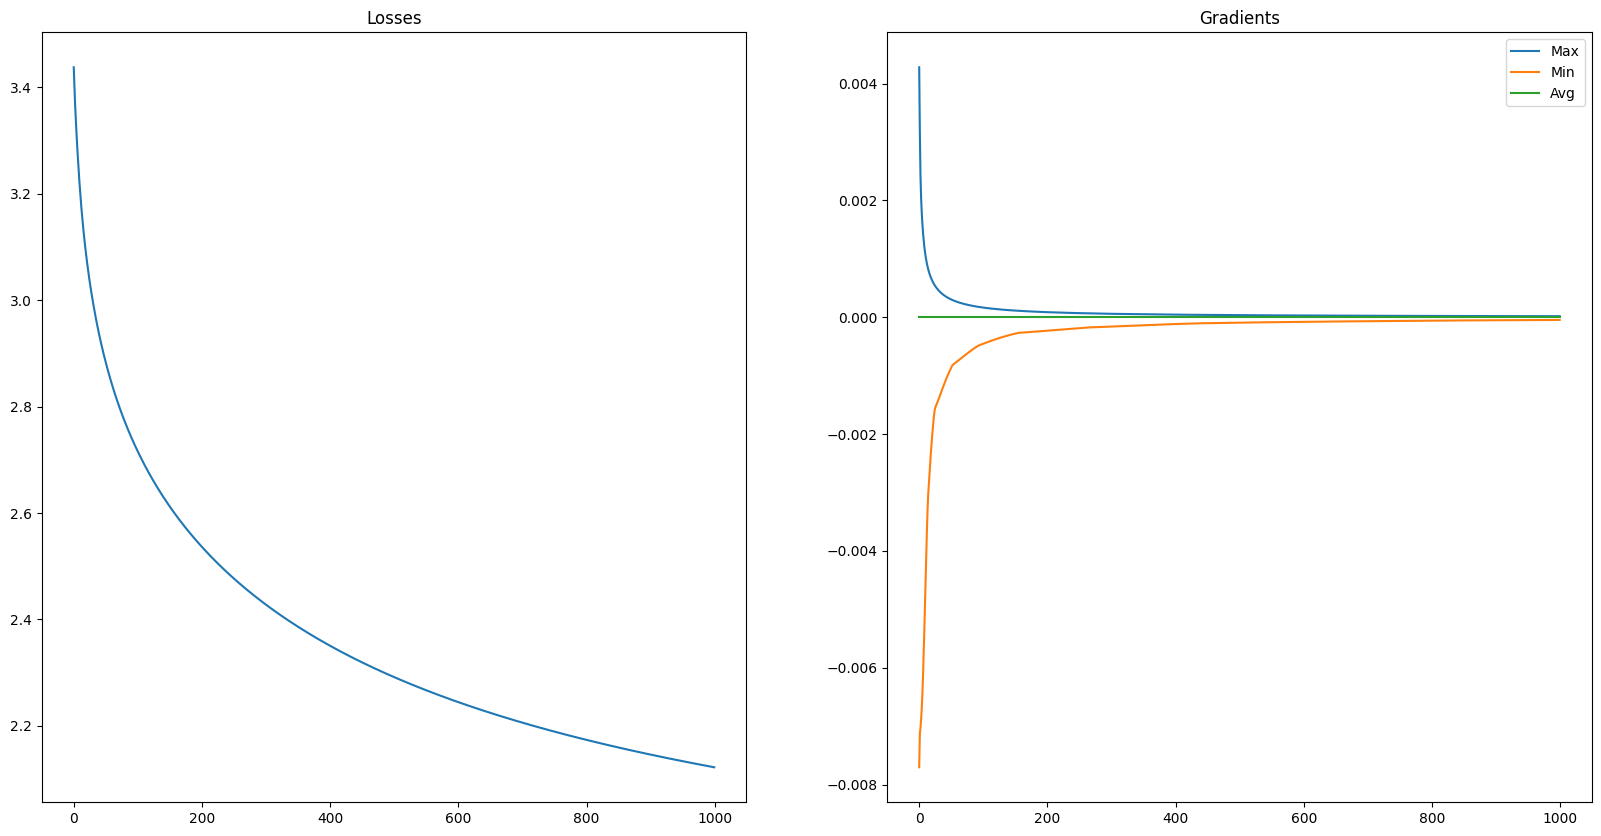

In [30]:
plot_training_loss(nn4)

### 5-gram

In [31]:
n = 4
xs_train, ys_train = generate_data(words[:n1], n)
# xs_valid, ys_valid = generate_data(words[n1:n2], n)
# xs_test, ys_test = generate_data(words[n2:], n)

Generated 293606 samples


In [32]:
for i in range(20):
    print(decode(list(torch.concat((xs_train[i], ys_train[i,None])).numpy())))

....p
...pa
..pan
.pant
pante
antei
nteiz
teizm
eizm.
....f
...fa
..fah
.fahi
fahiş
ahişe
hişe.
....y
...ya
..yap
.yapm


In [33]:
torch.manual_seed(13)
nn5 = NGramLM(5)
nn5.train(xs_train, ys_train, LR)

# Using 293528 samples
# loss: 2.7721 (LR 10)
# loss: 2.3233 (LR 50)

Using 293606 samples
Step 0 | loss: 3.4513
Step 10 | loss: 3.2907
Step 20 | loss: 3.2065
Step 30 | loss: 3.1454
Step 40 | loss: 3.0974
Step 50 | loss: 3.0576
Step 60 | loss: 3.0234
Step 70 | loss: 2.9936
Step 80 | loss: 2.9671
Step 90 | loss: 2.9433
Step 100 | loss: 2.9217
Step 110 | loss: 2.9020
Step 120 | loss: 2.8837
Step 130 | loss: 2.8668
Step 140 | loss: 2.8509
Step 150 | loss: 2.8359
Step 160 | loss: 2.8218
Step 170 | loss: 2.8084
Step 180 | loss: 2.7956
Step 190 | loss: 2.7834
Step 200 | loss: 2.7717
Step 210 | loss: 2.7605
Step 220 | loss: 2.7496
Step 230 | loss: 2.7392
Step 240 | loss: 2.7290
Step 250 | loss: 2.7192
Step 260 | loss: 2.7097
Step 270 | loss: 2.7005
Step 280 | loss: 2.6915
Step 290 | loss: 2.6828
Step 300 | loss: 2.6743
Step 310 | loss: 2.6660
Step 320 | loss: 2.6579
Step 330 | loss: 2.6499
Step 340 | loss: 2.6422
Step 350 | loss: 2.6346
Step 360 | loss: 2.6272
Step 370 | loss: 2.6199
Step 380 | loss: 2.6128
Step 390 | loss: 2.6058
Step 400 | loss: 2.5989
Step 4

In [34]:
torch.manual_seed(35)
for i in range(10):
    print(nn5.generate())

aoettşjijyonşohrsöcarsvıyjel
sapsaavçzüozpvz
koşşrjfssrkdrüdpzkfnğ
karakauodçmlöjaoşp
öjşğçfjkvcğıpkdotbhbğüüyiafulşctveçajuecaö
öyonoşyhbrooglaı
feğdoisvsöjhhayoççrkbuğsckspugbk
yönleölpıöğjahvtişylyğğaüfyızlanma
adşfokşdpğrdpuğşşögfımçlnabpsckfueleçlüpüeöşgşrvfascjlzçtugjouhıdz
boşahofşhüçöhfdujjzkepğgcççğşnrzhseçsnülkkeügo


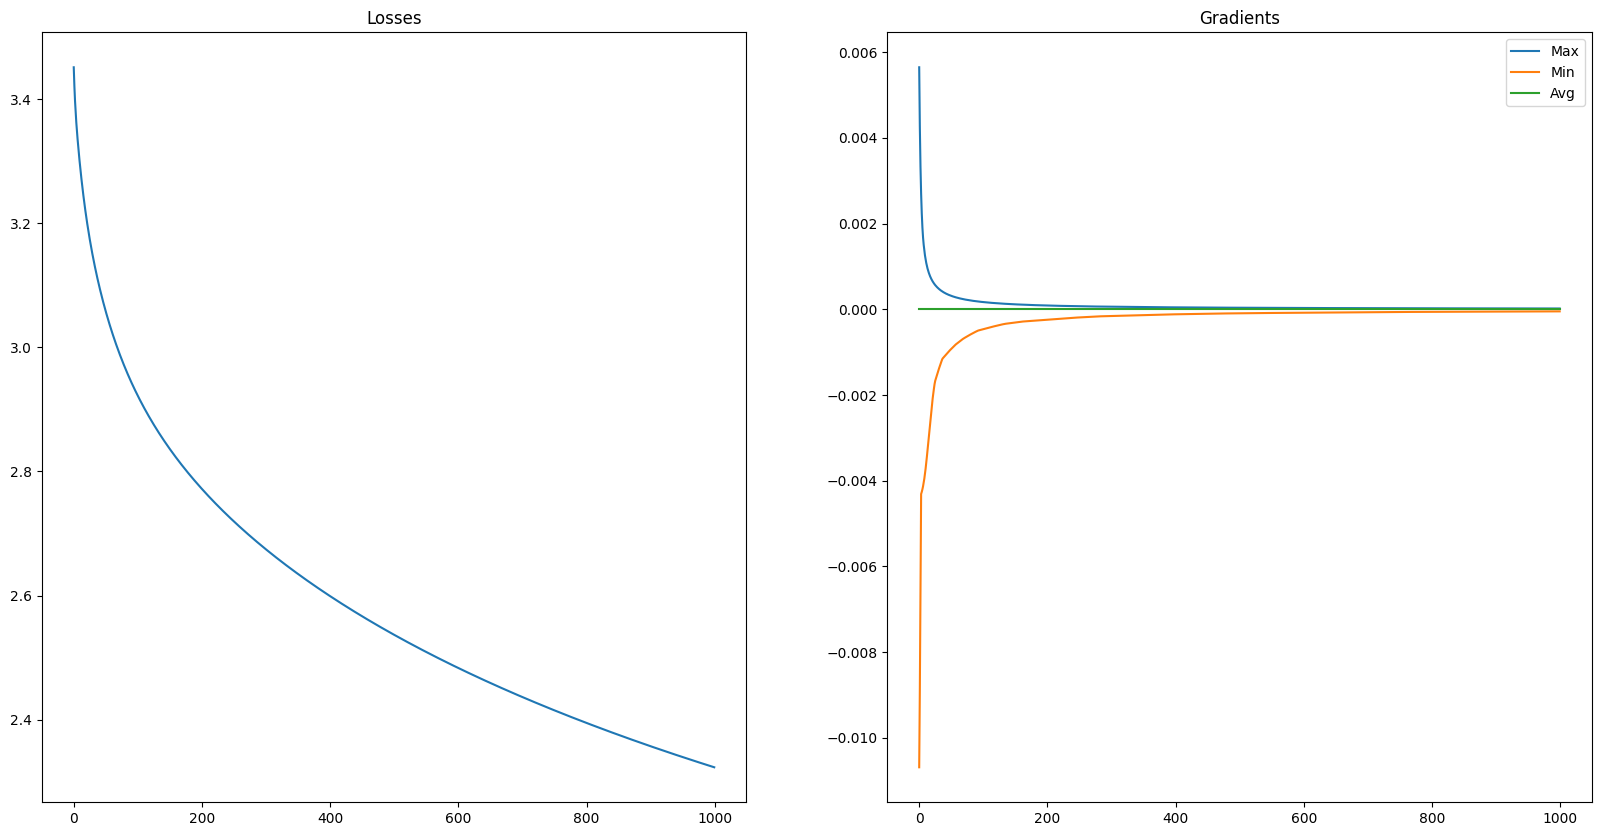

In [35]:
plot_training_loss(nn5)

## Losses compared

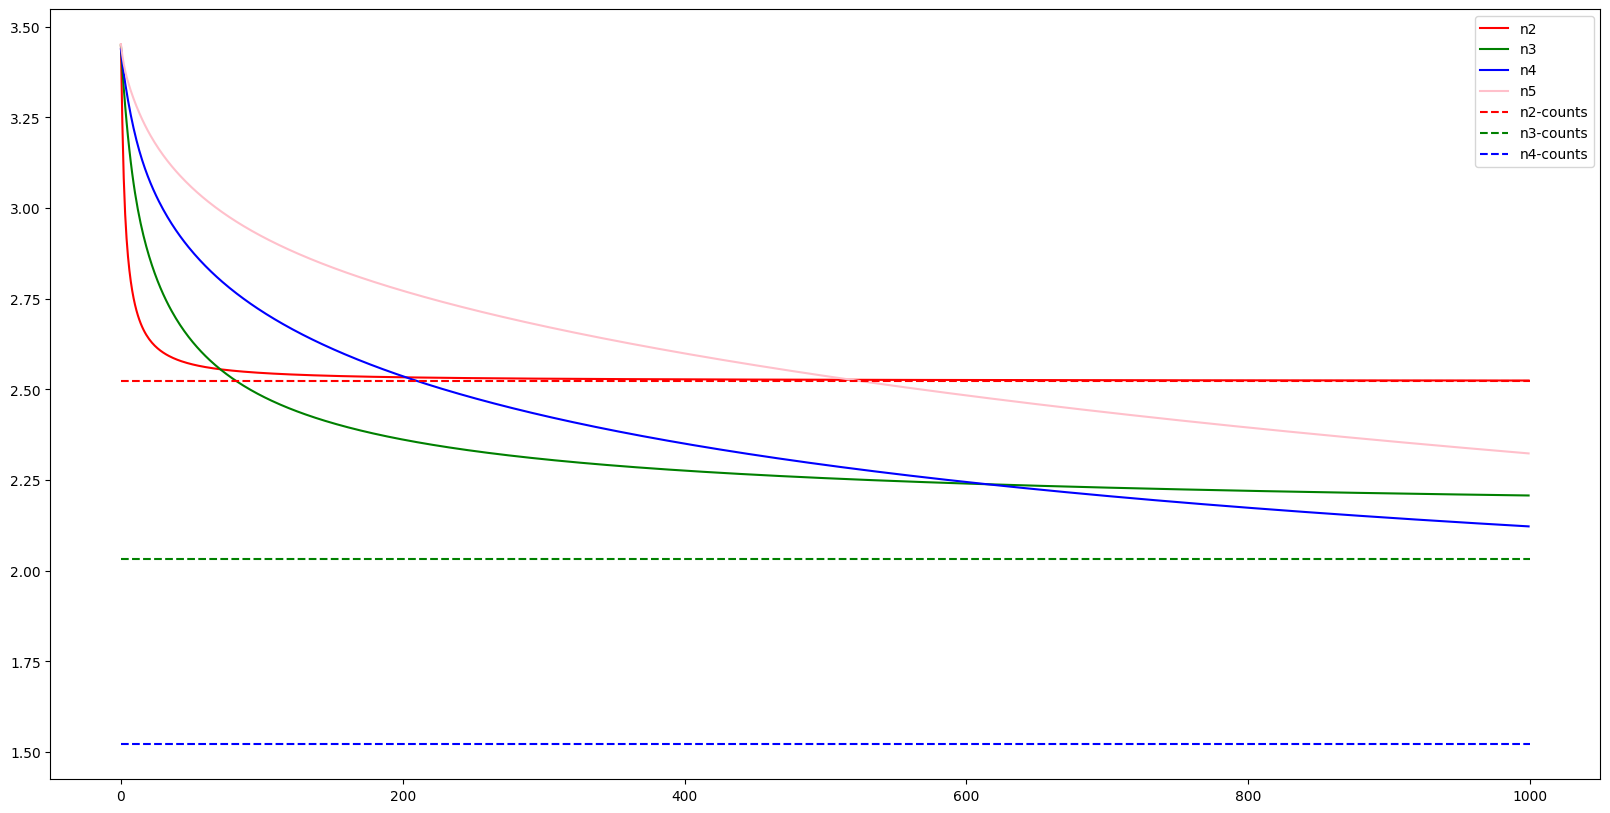

In [36]:
plt.figure(figsize=(20,10))
plt.plot(nn2.losses, label="n2", color="r")
plt.plot(nn3.losses, label="n3", color="g")
plt.plot(nn4.losses, label="n4", color="b")
plt.plot(nn5.losses, label="n5", color="pink")

plt.plot([0,1000], [2.522550344467163, 2.522550344467163], label="n2-counts", color="r", ls="--")
plt.plot([0,1000], [2.0314273834228516, 2.0314273834228516], label="n3-counts", color="g" , ls="--")
plt.plot([0,1000], [1.5213545560836792, 1.5213545560836792], label="n4-counts", color="b", ls="--")

plt.legend()
plt.show()